<a href="https://colab.research.google.com/github/aeau/MAU-AML-labs/blob/develop/1-computer-vision-lab/5_Captum_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example using CAPTUM!

# Setup

In [1]:
#XAI methods
! pip install captum kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.5 MB/s eta 0:00:00


In [2]:
pip install cmapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for cmapy: filename=cmapy-0.6.6-py3-none-any.whl size=3958 sha256=b7cd27a2ad5a3da505ac52165d01f6ec5e8d195c2daee7771248a1e6fab9f3a2
  Stored in directory: /root/.cache/pip/wheels/d0/ba/02/846115949970d31a249c4fb172d4e1249e3502050c3ee485d1
Successfully built cmapy


In [71]:
! pip install captum 
from captum.attr import Occlusion
from captum.attr import LayerGradCam
from captum.attr import LayerAttribution
from captum.attr import visualization as viz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
import os
import sys
import urllib
import json
import random

from io import StringIO ##For images
from io import BytesIO
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from torchvision import models
from torchvision import transforms
from torchvision.transforms import functional as transformsF
from captum.attr import IntegratedGradients
#from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import GuidedGradCam
from captum.attr import LayerGradCam
from captum.attr import LayerAttribution
from captum.attr import GradientShap
from captum.attr import Lime
from captum.attr import visualization as viz
#Extras for this test
import matplotlib.pyplot as plt
print(torch.__version__)
from zipfile import ZipFile
from random import randint

2.0.0+cu118


In [4]:
from torch.utils.data import Dataset
from torchvision import datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import copy

import json

In [5]:
# Set random seed for reproducibility.
np.random.seed(131254)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Authenticate in kaggle and download dataset

### We also download the test dataset from our own repository (drive for me)

REMEMBER TO CHANGE THE API KEY!

In [16]:
#The kaggle token
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

#Here you need your kaggle api_token! 
api_token = {"username":"your_username","key":"your_KEY!"} 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [17]:
! kaggle datasets download smeschke/four-shapes

 42% 9.00M/21.6M [00:00<00:00, 22.3MB/s]
100% 21.6M/21.6M [00:00<00:00, 50.0MB/s]


In [18]:
with ZipFile('/content/four-shapes.zip', 'r') as archive:
  archive.extractall('/content')


In [19]:
root_dir = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml'
data_path = "/content/data"
!unzip "/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/captum-shape-testset.zip" -d $data_path


Archive:  /content/drive/MyDrive/Work/PHD/courses-AML/data_aml/captum-shape-testset.zip
   creating: /content/data/captum-shape-testset/
  inflating: /content/data/captum-shape-testset/.DS_Store  
  inflating: /content/data/__MACOSX/captum-shape-testset/._.DS_Store  
   creating: /content/data/captum-shape-testset/set2/
  inflating: /content/data/__MACOSX/captum-shape-testset/._set2  
   creating: /content/data/captum-shape-testset/set1/
  inflating: /content/data/__MACOSX/captum-shape-testset/._set1  
  inflating: /content/data/captum-shape-testset/set2/Bild9.PNG  
  inflating: /content/data/__MACOSX/captum-shape-testset/set2/._Bild9.PNG  
  inflating: /content/data/captum-shape-testset/set2/Bild8.PNG  
  inflating: /content/data/__MACOSX/captum-shape-testset/set2/._Bild8.PNG  
  inflating: /content/data/captum-shape-testset/set2/Bild6.PNG  
  inflating: /content/data/__MACOSX/captum-shape-testset/set2/._Bild6.PNG  
  inflating: /content/data/captum-shape-testset/set2/Bild7.PNG  
  in

## Dataloader


In [20]:
# create the annotation file for the training!

from os import listdir
from os.path import isfile, join
import csv

shape_path = "/content/shapes"

shapes_to_ignore = ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']
labels_to_ignore = []

with open('/content/shapes/shapes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_location', 'label']) # Write header
    for dirs in listdir("/content/shapes"):
        if dirs in labels_to_ignore: #Ignore label!
          continue

#         print(dirs)
        if(dirs.endswith(".csv")):
            continue
        for f in listdir(join("/content/shapes", dirs)):

            if f in shapes_to_ignore: #ignore the images! 
              continue
            elif(join("/content/shapes", dirs, f).endswith(".csv")):
                continue
            elif isfile(join("/content/shapes", dirs, f)):
                writer.writerow([join(dirs, f), dirs])

In [21]:
num_classes = 4
possible_labels = {"circle": 0, "square": 1, "star": 2, "triangle": 3}
#possible_labels = {"circle": 0, "square": 1, "triangle": 2}
key_list = list(possible_labels.keys())
val_list = list(possible_labels.values())

def label_to_idx(label):
  return possible_labels[label]

def idx_to_label(idx):
  position = val_list.index(idx)
  return key_list[position]

In [22]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.resizer = transforms.Resize(size=(200, 200))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path) # Converts to tensor
        image = image.float()
        image /= 255.
        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(label_to_idx(label))

        # ADDDITIONS TO TRANSFORM THE INPUT
        r = random.random() # 33% (equal probability) to zoom-in, zoom-out, dont transform

        if r < 0.33: # We zoom-in the shape!
          top = random.randrange(0, 40) 
          left = top
          dif = 40 - top
          w = 120 + dif
          h = w
          image = transformsF.resized_crop(image, top, left, h, w, size=(200, 200))
        elif r < 0.66: # We zoom-out the shape!
          pad = random.randrange(0, 300)
          image = transforms.Pad(padding=pad, fill=1)(image)
          image = self.resizer(image)
        #else: We just use the image as is! 

        # END OF ADDITIONS!

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        image = image.repeat(3, 1, 1)
        
        return image, label

In [23]:
## dls = DataLoader
shapes_dataset = CustomImageDataset('/content/shapes/shapes.csv', '/content/shapes')
print(len(shapes_dataset))
input, label = shapes_dataset[0]
print(type(input))
print(input.shape)
print(type(label))
print(label)


training_size = int(len(shapes_dataset)*0.9)
validation_size = int(len(shapes_dataset) - training_size)
print(training_size)
print(validation_size)
train_set, val_set = torch.utils.data.random_split(shapes_dataset, [training_size, validation_size])

training_loader = DataLoader(train_set, batch_size=64, shuffle=True)
validation_loader = DataLoader(val_set, batch_size=64, shuffle=True)



14930
<class 'torch.Tensor'>
torch.Size([3, 200, 200])
<class 'torch.Tensor'>
tensor(1)
13437
1493


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# Visualize the training set! 

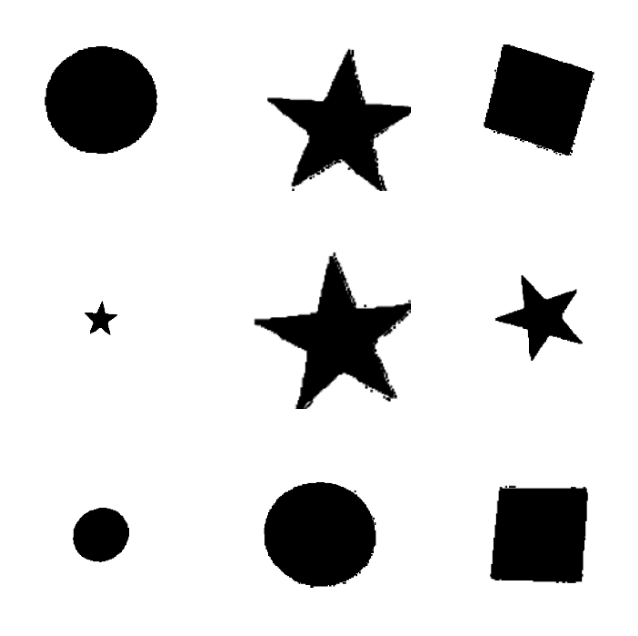

In [24]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(shapes_dataset), size=(1,)).item() # Get rnd_id
    sample = shapes_dataset[sample_idx] # index dataset (gets you the img and label - index)
    img, label = shapes_dataset[sample_idx] # index dataset (gets you the img and label - index)
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
#    plt.imshow(img.squeeze(), cmap="gray") # if the image is grayscale
    plt.imshow(img.permute(1,2,0)) # put channel as the last dimension
plt.show()

# TRAIN AND TEST THE MODELS! 

Change the following cell the parameter (pretrained=True) to get a pretrained model 

In [25]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [26]:
%%capture
pretrained = False
feature_extract = False #False means we retrain the whole network, True = Freeze the weights, train only the last layer
# feature extracting does not matter if pretrained=False

#Do the torch thing
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True #Skum grej från https://github.com/pytorch/pytorch/issues/61755
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=pretrained)

In [27]:
#We change the final layer!

model_ft = model
set_parameter_requires_grad(model_ft, feature_extract) #This is done first to know if we need to freeze the already "working" part!
num_ftrs = model_ft.fc.in_features  # Get what the final layer should receive

# Here the size of each output sample is set to 4 (the shape names)
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.to(device)

In [28]:
def train_model(model, criterion, optimizer):
    since = time.time()
    best_acc = 0.0
    model.train()   # Set model to train mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / training_size
    epoch_acc = running_corrects.double() / training_size

    print('train Loss: {:.4f} Acc: {:.4f}'.format(
         epoch_loss, epoch_acc))

In [29]:
def test_model(model, criterion):
    since = time.time()
    best_acc = 0.0
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / validation_size
    epoch_acc = running_corrects.double() / validation_size

    print('test Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

In [30]:
num_epochs = 4

criterion = nn.CrossEntropyLoss()

# We are optimizing
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs... Not relevant if 4 epochs!
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [31]:
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print()
    train_model(model_ft, criterion, optimizer_ft)
    test_model(model_ft, criterion)
    scheduler.step()

Epoch 0/3

train Loss: 0.7962 Acc: 0.6449
test Loss: 0.2757 Acc: 0.9678
Epoch 1/3

train Loss: 0.1750 Acc: 0.9642
test Loss: 0.0908 Acc: 0.9786
Epoch 2/3

train Loss: 0.0656 Acc: 0.9883
test Loss: 0.0214 Acc: 1.0000
Epoch 3/3

train Loss: 0.0517 Acc: 0.9884
test Loss: 0.0118 Acc: 1.0000


In [32]:
for epoch in range(1):
  test_model(model_ft, criterion)

test Loss: 0.0126 Acc: 0.9993


# SAVE/LOAD MODELS 

In [ ]:
# Change to your paths!
testset_path="/content/data/captum-shape-testset/set1/"
model_save_path = "/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/models/CAPTUM-models/"

model_weights_no_pretrained = model_save_path + 'shapes_resnet50model_not_pretrained_weights.pth'
complete_model_no_pretrained = model_save_path + 'shapes_resnet50model_not_pretrained.pth'

In [ ]:
ls -a $testset_path

./   Bild1.PNG  Bild3.PNG  Bild5.PNG  Bild7.PNG  Bild9.PNG
../  Bild2.PNG  Bild4.PNG  Bild6.PNG  Bild8.PNG


## SAVE MODELS

In [ ]:
#Save NO PRETRAINED!
torch.save(model_ft.state_dict(), model_weights_no_pretrained)
torch.save(model_ft, complete_model_no_pretrained)

In [ ]:
#Save PRETRAINED
torch.save(model_ft.state_dict(), model_weights_pretrained)
torch.save(model_ft, complete_model_pretrained)

In [ ]:
#Save PRETRAINED FREEZE WEIGHTS
torch.save(model_ft.state_dict(), model_weights_pretrained_freeze)
torch.save(model_ft, complete_model_pretrained_freeze)

## LOAD THE MODELS! 

In [ ]:
#And then training the model
%%capture
#Do the torch thing
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True #Skum grej från https://github.com/pytorch/pytorch/issues/61755
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()
model

### Pretrained model

In [ ]:
%%capture
num_ftrs = model.fc.in_features # Get what the final layer should receive

# Here the size of each output sample is set to 2 (the class names)
# Create a new final layer
model.fc = nn.Linear(num_ftrs, 4)

model_ft = model
model_ft.load_state_dict(torch.load(model_weights_pretrained, map_location=torch.device(device)))
model_ft.eval()
model_ft = model_ft.to(device)

In [ ]:
model_ft = model
model_ft = torch.load(complete_model_pretrained, map_location=torch.device(device))
model_ft.eval()
model_ft = model_ft.to(device)

### Not Pretrained model

In [ ]:
num_ftrs = model.fc.in_features # Get what the final layer should receive

# Here the size of each output sample is set to 2 (the class names)
# Create a new final layer
model.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model
model_ft = torch.load(complete_model_no_pretrained, map_location=torch.device(device))
model_ft.eval()
model_ft = model_ft.to(device)

In [ ]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# XAI Methods - Captum


https://captum.ai/tutorials/

In [93]:
method="blended_heat_map"#"heat_map" #"blended_heat_map"
#method='heat_map'
sign="positive" #positive
alpha_overlay = 0.6
default_cmap = LinearSegmentedColormap.from_list('custom green', 
                                                 [(0, '#39422c'),
                                                  (1, '#8df505')], N=5)

In [34]:
def show_image(image, prediction):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.title(prediction)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [35]:
from skimage import io, transform
from PIL import Image

eval_transform = transforms.Compose([
        transforms.Resize((200, 200)),
        #transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

def transform_eval_data(img_path, eval_transform = None):
  image = Image.open(img_path).convert('RGB')
  
  if eval_transform:
      image = eval_transform(image)
  image = image.float()
  return image
        

In [ ]:
## HELPER METHODS

## HELPER METHODS


In [80]:
from numpy import ndarray
from typing import Any, Iterable, List, Optional, Tuple, Union
from matplotlib.figure import Figure
from matplotlib.pyplot import axis, figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from enum import Enum
import warnings

class VisualizeSign(Enum):
    positive = 1
    absolute_value = 2
    negative = 3
    all = 4

class ImageVisualizationMethod(Enum):
    heat_map = 1
    blended_heat_map = 2
    original_image = 3
    masked_image = 4
    alpha_scaling = 5

In [81]:
def _normalize_scale(attr: ndarray, scale_factor: float):
    assert scale_factor != 0, "Cannot normalize by scale factor = 0"
    if abs(scale_factor) < 1e-5:
        warnings.warn(
            "Attempting to normalize by value approximately 0, visualized results"
            "may be misleading. This likely means that attribution values are all"
            "close to 0."
        )
    attr_norm = attr / scale_factor
    return np.clip(attr_norm, -1, 1)

In [82]:
def _cumulative_sum_threshold(values: ndarray, percentile: Union[int, float]):
    # given values should be non-negative
    assert percentile >= 0 and percentile <= 100, (
        "Percentile for thresholding must be " "between 0 and 100 inclusive."
    )
    sorted_vals = np.sort(values.flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id = np.where(cum_sums >= cum_sums[-1] * 0.01 * percentile)[0][0]
    return sorted_vals[threshold_id]

In [83]:
def _prepare_image(attr_visual: ndarray):
    return np.clip(attr_visual.astype(int), 0, 255)

In [84]:
def _normalize_attr(
    attr: ndarray,
    sign: str,
    outlier_perc: Union[int, float] = 2,
    reduction_axis: Optional[int] = None,
):
    attr_combined = attr
    if reduction_axis is not None:
        attr_combined = np.sum(attr, axis=reduction_axis)

    # Choose appropriate signed values and rescale, removing given outlier percentage.
    if VisualizeSign[sign] == VisualizeSign.all:
        threshold = _cumulative_sum_threshold(np.abs(attr_combined), 100 - outlier_perc)
    elif VisualizeSign[sign] == VisualizeSign.positive:
        attr_combined = (attr_combined > 0) * attr_combined
        threshold = _cumulative_sum_threshold(attr_combined, 100 - outlier_perc)
    elif VisualizeSign[sign] == VisualizeSign.negative:
        attr_combined = (attr_combined < 0) * attr_combined
        threshold = -1 * _cumulative_sum_threshold(
            np.abs(attr_combined), 100 - outlier_perc
        )
    elif VisualizeSign[sign] == VisualizeSign.absolute_value:
        attr_combined = np.abs(attr_combined)
        threshold = _cumulative_sum_threshold(attr_combined, 100 - outlier_perc)
    else:
        raise AssertionError("Visualize Sign type is not valid.")
    return _normalize_scale(attr_combined, threshold)

In [95]:
def visualize_image_attr(
    attr: ndarray,
    original_image: Union[None, ndarray] = None,
    method: str = "heat_map",
    sign: str = "absolute_value",
    plt_fig_axis: Union[None, Tuple[figure, axis]] = None,
    outlier_perc: Union[int, float] = 2,
    cmap: Union[None, str] = None,
    alpha_overlay: float = 0.5,
    show_colorbar: bool = False,
    title: Union[None, str] = None,
    fig_size: Tuple[int, int] = (6, 6),
    use_pyplot: bool = True,
):
    r"""
    Visualizes attribution for a given image by normalizing attribution values
    of the desired sign (positive, negative, absolute value, or all) and displaying
    them using the desired mode in a matplotlib figure.
    Args:
        attr (numpy.ndarray): Numpy array corresponding to attributions to be
                    visualized. Shape must be in the form (H, W, C), with
                    channels as last dimension. Shape must also match that of
                    the original image if provided.
        original_image (numpy.ndarray, optional): Numpy array corresponding to
                    original image. Shape must be in the form (H, W, C), with
                    channels as the last dimension. Image can be provided either
                    with float values in range 0-1 or int values between 0-255.
                    This is a necessary argument for any visualization method
                    which utilizes the original image.
                    Default: None
        method (str, optional): Chosen method for visualizing attribution.
                    Supported options are:
                    1. `heat_map` - Display heat map of chosen attributions
                    2. `blended_heat_map` - Overlay heat map over greyscale
                       version of original image. Parameter alpha_overlay
                       corresponds to alpha of heat map.
                    3. `original_image` - Only display original image.
                    4. `masked_image` - Mask image (pixel-wise multiply)
                       by normalized attribution values.
                    5. `alpha_scaling` - Sets alpha channel of each pixel
                       to be equal to normalized attribution value.
                    Default: `heat_map`
        sign (str, optional): Chosen sign of attributions to visualize. Supported
                    options are:
                    1. `positive` - Displays only positive pixel attributions.
                    2. `absolute_value` - Displays absolute value of
                       attributions.
                    3. `negative` - Displays only negative pixel attributions.
                    4. `all` - Displays both positive and negative attribution
                       values. This is not supported for `masked_image` or
                       `alpha_scaling` modes, since signed information cannot
                       be represented in these modes.
                    Default: `absolute_value`
        plt_fig_axis (tuple, optional): Tuple of matplotlib.pyplot.figure and axis
                    on which to visualize. If None is provided, then a new figure
                    and axis are created.
                    Default: None
        outlier_perc (float or int, optional): Top attribution values which
                    correspond to a total of outlier_perc percentage of the
                    total attribution are set to 1 and scaling is performed
                    using the minimum of these values. For sign=`all`, outliers
                    and scale value are computed using absolute value of
                    attributions.
                    Default: 2
        cmap (str, optional): String corresponding to desired colormap for
                    heatmap visualization. This defaults to "Reds" for negative
                    sign, "Blues" for absolute value, "Greens" for positive sign,
                    and a spectrum from red to green for all. Note that this
                    argument is only used for visualizations displaying heatmaps.
                    Default: None
        alpha_overlay (float, optional): Alpha to set for heatmap when using
                    `blended_heat_map` visualization mode, which overlays the
                    heat map over the greyscaled original image.
                    Default: 0.5
        show_colorbar (bool, optional): Displays colorbar for heatmap below
                    the visualization. If given method does not use a heatmap,
                    then a colormap axis is created and hidden. This is
                    necessary for appropriate alignment when visualizing
                    multiple plots, some with colorbars and some without.
                    Default: False
        title (str, optional): Title string for plot. If None, no title is
                    set.
                    Default: None
        fig_size (tuple, optional): Size of figure created.
                    Default: (6,6)
        use_pyplot (bool, optional): If true, uses pyplot to create and show
                    figure and displays the figure after creating. If False,
                    uses Matplotlib object oriented API and simply returns a
                    figure object without showing.
                    Default: True.
    Returns:
        2-element tuple of **figure**, **axis**:
        - **figure** (*matplotlib.pyplot.figure*):
                    Figure object on which visualization
                    is created. If plt_fig_axis argument is given, this is the
                    same figure provided.
        - **axis** (*matplotlib.pyplot.axis*):
                    Axis object on which visualization
                    is created. If plt_fig_axis argument is given, this is the
                    same axis provided.
    Examples::
        >>> # ImageClassifier takes a single input tensor of images Nx3x32x32,
        >>> # and returns an Nx10 tensor of class probabilities.
        >>> net = ImageClassifier()
        >>> ig = IntegratedGradients(net)
        >>> # Computes integrated gradients for class 3 for a given image .
        >>> attribution, delta = ig.attribute(orig_image, target=3)
        >>> # Displays blended heat map visualization of computed attributions.
        >>> _ = visualize_image_attr(attribution, orig_image, "blended_heat_map")
    """
    # Create plot if figure, axis not provided
    if plt_fig_axis is not None:
        plt_fig, plt_axis = plt_fig_axis
    else:
        if use_pyplot:
            plt_fig, plt_axis = plt.subplots(figsize=fig_size)
        else:
            plt_fig = Figure(figsize=fig_size)
            plt_axis = plt_fig.subplots()

    if original_image is not None:
        if np.max(original_image) <= 1.0:
            original_image = _prepare_image(original_image * 255)
    elif ImageVisualizationMethod[method] != ImageVisualizationMethod.heat_map:
        raise ValueError(
            "Original Image must be provided for"
            "any visualization other than heatmap."
        )

    # Remove ticks and tick labels from plot.
    plt_axis.xaxis.set_ticks_position("none")
    plt_axis.yaxis.set_ticks_position("none")
    plt_axis.set_yticklabels([])
    plt_axis.set_xticklabels([])
    # plt_axis.grid(b=False)
    plt_axis.grid(visible=False)

    heat_map = None
    # Show original image
    if ImageVisualizationMethod[method] == ImageVisualizationMethod.original_image:
        assert (
            original_image is not None
        ), "Original image expected for original_image method."
        if len(original_image.shape) > 2 and original_image.shape[2] == 1:
            original_image = np.squeeze(original_image, axis=2)
        plt_axis.imshow(original_image)
    else:
        # Choose appropriate signed attributions and normalize.
        norm_attr = _normalize_attr(attr, sign, outlier_perc, reduction_axis=2)

        # Set default colormap and bounds based on sign.
        if VisualizeSign[sign] == VisualizeSign.all:
            default_cmap = LinearSegmentedColormap.from_list(
                "RdWhGn", ["red", "white", "green"]
            )
            vmin, vmax = -1, 1
        elif VisualizeSign[sign] == VisualizeSign.positive:
            default_cmap = "Greens"
            vmin, vmax = 0, 1
        elif VisualizeSign[sign] == VisualizeSign.negative:
            default_cmap = "Reds"
            vmin, vmax = 0, 1
        elif VisualizeSign[sign] == VisualizeSign.absolute_value:
            default_cmap = "Blues"
            vmin, vmax = 0, 1
        else:
            raise AssertionError("Visualize Sign type is not valid.")
        cmap = cmap if cmap is not None else default_cmap

        # Show appropriate image visualization.
        if ImageVisualizationMethod[method] == ImageVisualizationMethod.heat_map:
            heat_map = plt_axis.imshow(norm_attr, cmap=cmap, vmin=vmin, vmax=vmax)
        elif (
            ImageVisualizationMethod[method]
            == ImageVisualizationMethod.blended_heat_map
        ):
            assert (
                original_image is not None
            ), "Original Image expected for blended_heat_map method."
            plt_axis.imshow(np.mean(original_image, axis=2), cmap="gray")
            heat_map = plt_axis.imshow(
                norm_attr, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha_overlay
            )
        elif ImageVisualizationMethod[method] == ImageVisualizationMethod.masked_image:
            assert VisualizeSign[sign] != VisualizeSign.all, (
                "Cannot display masked image with both positive and negative "
                "attributions, choose a different sign option."
            )
            plt_axis.imshow(
                _prepare_image(original_image * np.expand_dims(norm_attr, 2))
            )
        elif ImageVisualizationMethod[method] == ImageVisualizationMethod.alpha_scaling:
            assert VisualizeSign[sign] != VisualizeSign.all, (
                "Cannot display alpha scaling with both positive and negative "
                "attributions, choose a different sign option."
            )
            plt_axis.imshow(
                np.concatenate(
                    [
                        original_image,
                        _prepare_image(np.expand_dims(norm_attr, 2) * 255),
                    ],
                    axis=2,
                )
            )
        else:
            raise AssertionError("Visualize Method type is not valid.")

    # Add colorbar. If given method is not a heatmap and no colormap is relevant,
    # then a colormap axis is created and hidden. This is necessary for appropriate
    # alignment when visualizing multiple plots, some with heatmaps and some
    # without.
    if show_colorbar:
        axis_separator = make_axes_locatable(plt_axis)
        colorbar_axis = axis_separator.append_axes("bottom", size="5%", pad=0.1)
        if heat_map:
            plt_fig.colorbar(heat_map, orientation="horizontal", cax=colorbar_axis)
        else:
            colorbar_axis.axis("off")
    if title:
        plt_axis.set_title(title)

    if use_pyplot:
        plt.show()

    return plt_fig, plt_axis 

## XAI METHODS separated in Functions to be called!

In [97]:
def calculate_occlusion(experiment_model, target_label, input_img, top_candidates, top_probs, img_index, save_path="", save=False):

  experiment_model = experiment_model.to(device)
  input_img = input_img.to(device)

  #experiment_model.zero_grad()

  occlusion = Occlusion(experiment_model)
  
  # Usual
  attributions = occlusion.attribute(input_img,
                                    strides = (3, 25, 25),
                                    sliding_window_shapes=(3,50, 50),
                                    target=target_label,
                                    baselines = 0)

  # Remove the fake batch dimension
  input_img = input_img.squeeze()

  result = visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                              input_img.cpu().permute(1,2,0).detach().numpy(), 
                              #cmap=default_cmap,
                              alpha_overlay=alpha_overlay,
                              method=method,
                              sign=sign,
                              fig_size=(5,5))
  
  # Usually you would just use this. However, there is a bug (at least on my end)
  # regarding the grid. So I have just copied the code from CAPTUMs repository (the parts that are necessary)
  # reimplementing a bit, and changing the part of the code with the problem

  # result = viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
  #                             input_img.cpu().permute(1,2,0).detach().numpy(), 
  #                             #cmap=default_cmap,
  #                             alpha_overlay=alpha_overlay,
  #                             method=method,
  #                             sign=sign,
  #                             fig_size=(5,5))
  
  print(target_label, idx_to_label(top_candidates[0]), np.round(top_probs[0].item(),2))
  if save:
    n=str(img_index + 1)
    result[0].savefig(save_path+'Bild'+n+ '_' + str(idx_to_label(target_label)) + '_Occ.PNG',bbox_inches='tight', pad_inches = 0)

In [61]:
def eval_model(experiment_set, test_model, print_eval=False):
  since = time.time()
  test_model.eval()   # Set model to evaluate mode

  for experiment_sample in experiment_set:
    torch.set_printoptions(sci_mode=False)

    with torch.no_grad():
      input = experiment_sample
      input = torch.unsqueeze(input, 0)
      input = input.to(device)
      #print(input.shape)
      output = test_model(input)
      _, pred = torch.max(output, 1)

      input= input.cpu().squeeze()
      smax = F.softmax(output,dim=1)
      print("prediction: ", pred, ", label: ", idx_to_label(pred))

      if print_eval:
        show_image(input.permute(1,2,0), idx_to_label(pred))
        print(smax)
        print("---------")

def get_all_files(experiment_path):
  loaded_files = []
  for f in sorted(os.listdir(experiment_path)):
    if f.endswith('.PNG') or f.endswith('.png'):
      loaded_files.append(f)
  #print(loaded_files)
  return loaded_files

def load_experiment_data(experiment_path, test_model, plot_data=False, evaluate_model=False, print_evaluation=False):
  experiment_set = []
  eval_dir = get_all_files(experiment_path)
  eval_size = len(eval_dir)
  for i in range(eval_size):
    experiment_set.append(transform_eval_data(experiment_path + eval_dir[i]
                                      ,eval_transform))
  
  if plot_data:
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        #sample_idx = torch.randint(len(shapes_dataset), size=(1,)).item() # Get rnd_id
        img = experiment_set[i-1] # index dataset (gets you the img and label - index)
        figure.add_subplot(rows, cols, i)
        plt.title(img.shape)
        plt.axis("off")
    #    plt.imshow(img.squeeze(), cmap="gray") # if the image is grayscale
        plt.imshow(img.permute(1,2,0)) # put channel as the last dimension
    plt.show()
  
  if evaluate_model:
    eval_model(experiment_set, test_model, print_evaluation)

  return experiment_set

In [62]:
import pandas as pd

def process_input(input_img, experiment_model, debug=False):
  input_img = input_img.to(device)
  output = experiment_model(input_img)
  probabilities = F.softmax(output[0], dim=0)
  top_prob, top_catid = torch.topk(probabilities, num_classes)
  jsonData={}
  for i in range(top_prob.size(0)):
      prediction={}
      prob=top_prob[i].item()
      prediction["probability"] = np.round(top_prob[i].item(),9)
      prediction["label"] = idx_to_label(top_catid[i])
      prediction["labelid"] = top_catid[i].item()
      jsonData[i]=prediction
  ###
  #LH:label= top5_catid[0].item()
  #label= top_catid[0].item()
  if debug:
    #print(label,jsonData)
    print(jsonData)

  #output = model(input_img)
  #output = F.softmax(output, dim=1)
  #prediction_score, pred_label_idx = torch.topk(output, 1)
  #pred_label_idx.squeeze_()
  #predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
  #print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

  return top_catid, top_prob, jsonData

In [63]:
import json

def run_experiment_shapes(experiment_model, experiment_path, experiment_name, save_path="", label_id=0, index=-1, save=False, debug=False):
  print(experiment_name)
  experiment_set = load_experiment_data(experiment_path,  experiment_model, plot_data=False, evaluate_model = False, print_evaluation=False)
  print("------------------")
  path_to_save = save_path + experiment_name.replace(" ", "") + "/"
  print("Save Path: ", path_to_save)

  if not os.path.exists(path_to_save):
    print("this happens")
    os.makedirs(path_to_save)

  json_data = {}

  if index == -1: # Iterate all the experiment set! else only the specific index is 
    for idx, experiment_sample in enumerate(experiment_set):
      ignore_indices = []
      if idx in ignore_indices:
        continue

      experiment_sample = experiment_sample.unsqueeze(0)
      top_candidates, top_probs, jdata = process_input(experiment_sample, experiment_model, debug=debug)
      json_data[idx] = jdata
      print("Selected label: ", top_candidates[label_id] )
      print("target_label: ", top_candidates[label_id].item())

      calculate_occlusion(experiment_model, 
                              target_label=top_candidates[label_id],
                              input_img=experiment_sample,
                              top_candidates=top_candidates, top_probs=top_probs,
                              img_index=idx, save_path=path_to_save, save=save)


  else:
      experiment_sample = experiment_set[index]
      experiment_sample = experiment_sample.unsqueeze(0)

      top_candidates, top_probs = process_input(experiment_sample, experiment_model, debug=debug)
      target_label = top_candidates[label_id].item()
      print("Selected label: ", top_candidates[label_id] )
      print("target_label: ", top_candidates[label_id].item())

      calculate_occlusion(experiment_model, 
                              target_label=target_label,
                              input_img=experiment_sample,
                              top_candidates=top_candidates, top_probs=top_probs,
                              img_index=index, save_path=path_to_save, save=save)
      
  save_json = json.dumps(json_data)
  with open(path_to_save + 'label_info.json', 'w') as outfile:
    outfile.write(save_json)

## Run the experiments!

Set1 no_pret
------------------
Save Path:  random_pathSet1no_pret/
{0: {'probability': 0.984671652, 'label': 'circle', 'labelid': 0}, 1: {'probability': 0.015325804, 'label': 'square', 'labelid': 1}, 2: {'probability': 2.536e-06, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(0, device='cuda:0')
target_label:  0


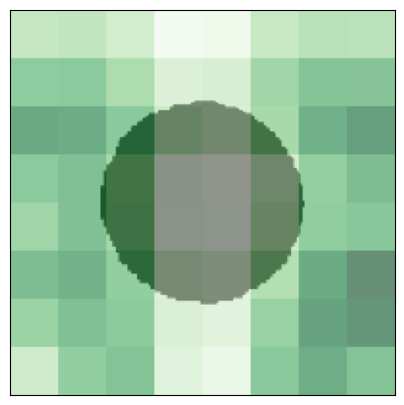

tensor(0, device='cuda:0') circle 0.98
{0: {'probability': 0.996528208, 'label': 'square', 'labelid': 1}, 1: {'probability': 0.002891603, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.000580159, 'label': 'circle', 'labelid': 0}, 3: {'probability': 1e-08, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(1, device='cuda:0')
target_label:  1


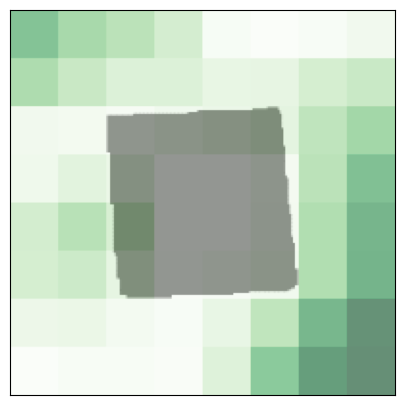

tensor(1, device='cuda:0') square 1.0
{0: {'probability': 0.999198258, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.000801713, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


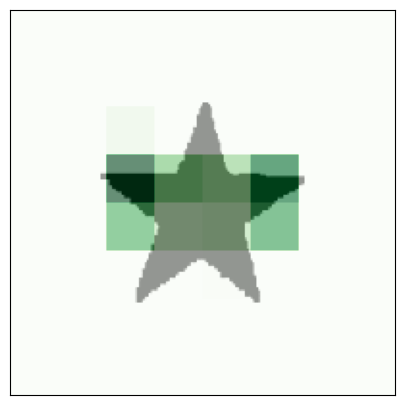

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.99672395, 'label': 'triangle', 'labelid': 3}, 1: {'probability': 0.001739522, 'label': 'square', 'labelid': 1}, 2: {'probability': 0.001536595, 'label': 'star', 'labelid': 2}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(3, device='cuda:0')
target_label:  3


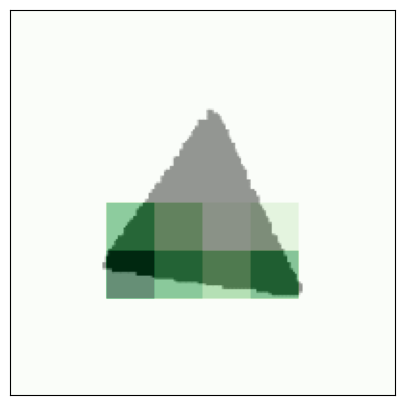

tensor(3, device='cuda:0') triangle 1.0
{0: {'probability': 0.994542718, 'label': 'circle', 'labelid': 0}, 1: {'probability': 0.005455879, 'label': 'square', 'labelid': 1}, 2: {'probability': 1.407e-06, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(0, device='cuda:0')
target_label:  0


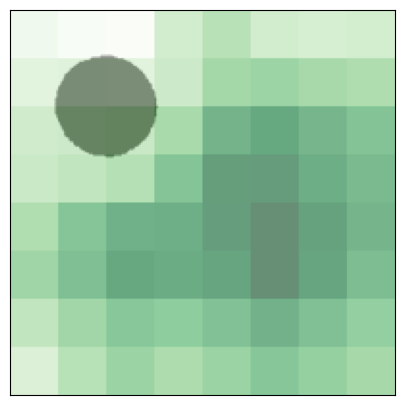

tensor(0, device='cuda:0') circle 0.99
{0: {'probability': 0.987713575, 'label': 'square', 'labelid': 1}, 1: {'probability': 0.009789351, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.002496917, 'label': 'circle', 'labelid': 0}, 3: {'probability': 4.1e-08, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(1, device='cuda:0')
target_label:  1


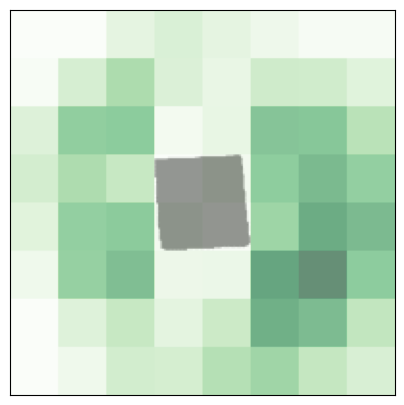

tensor(1, device='cuda:0') square 0.99
{0: {'probability': 0.629782379, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.370217592, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 2e-09, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


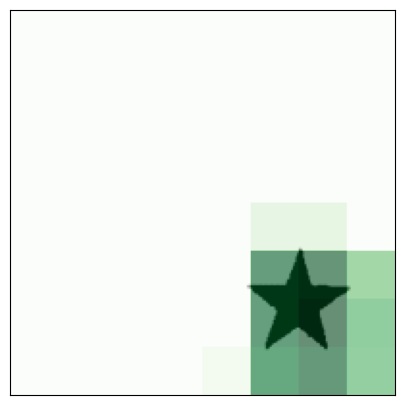

tensor(2, device='cuda:0') star 0.63
{0: {'probability': 0.984995425, 'label': 'triangle', 'labelid': 3}, 1: {'probability': 0.014770901, 'label': 'star', 'labelid': 2}, 2: {'probability': 0.000233678, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(3, device='cuda:0')
target_label:  3


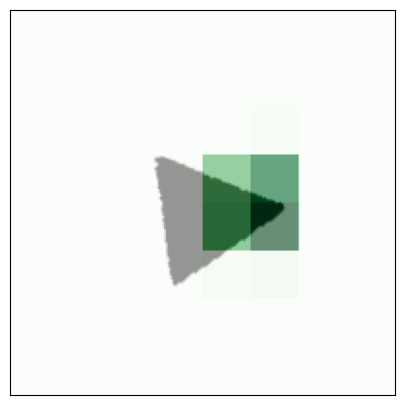

tensor(3, device='cuda:0') triangle 0.98
{0: {'probability': 0.994957983, 'label': 'triangle', 'labelid': 3}, 1: {'probability': 0.004862629, 'label': 'square', 'labelid': 1}, 2: {'probability': 0.000179396, 'label': 'star', 'labelid': 2}, 3: {'probability': 6.4e-08, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(3, device='cuda:0')
target_label:  3


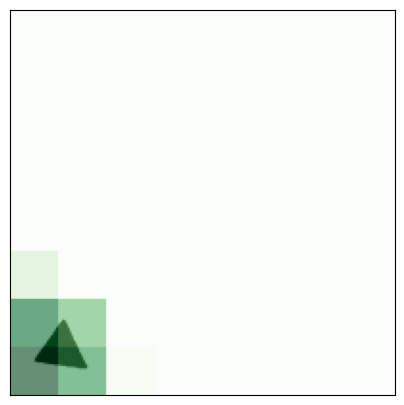

tensor(3, device='cuda:0') triangle 0.99
Set2 no_pret
------------------
Save Path:  random_pathSet2no_pret/
{0: {'probability': 0.999999523, 'label': 'star', 'labelid': 2}, 1: {'probability': 4.89e-07, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


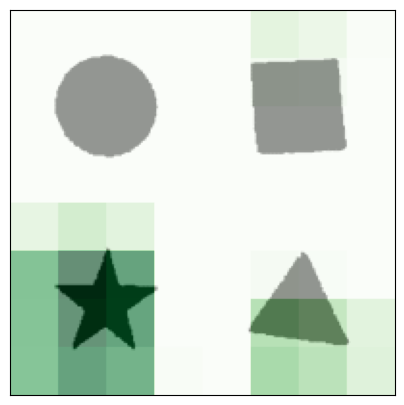

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.999999523, 'label': 'star', 'labelid': 2}, 1: {'probability': 4.85e-07, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


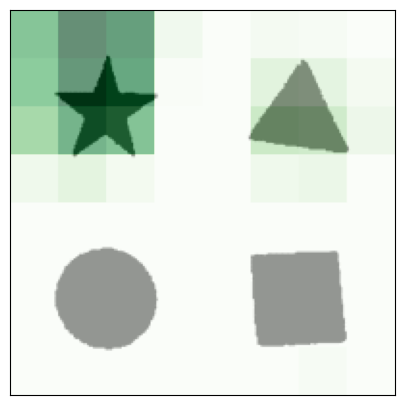

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.699350893, 'label': 'square', 'labelid': 1}, 1: {'probability': 0.300454378, 'label': 'circle', 'labelid': 0}, 2: {'probability': 0.000194639, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(1, device='cuda:0')
target_label:  1


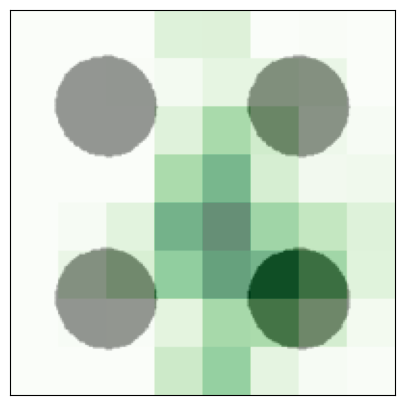

tensor(1, device='cuda:0') square 0.7
{0: {'probability': 1.0, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.0, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


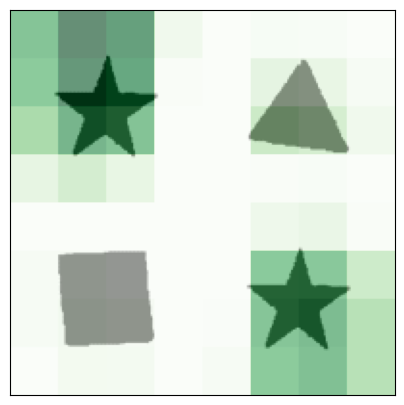

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.999984503, 'label': 'star', 'labelid': 2}, 1: {'probability': 1.5542e-05, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


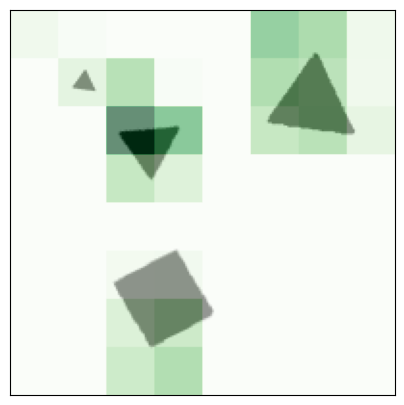

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.889199615, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.110800333, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


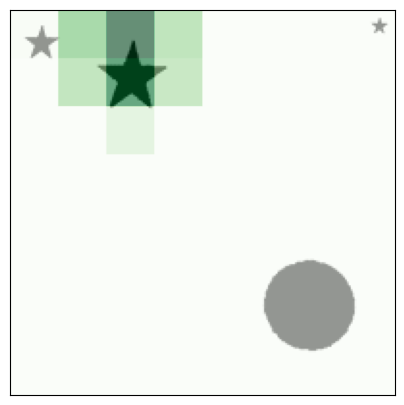

tensor(2, device='cuda:0') star 0.89
{0: {'probability': 0.993110538, 'label': 'square', 'labelid': 1}, 1: {'probability': 0.004248204, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.002641203, 'label': 'circle', 'labelid': 0}, 3: {'probability': 1.9e-08, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(1, device='cuda:0')
target_label:  1


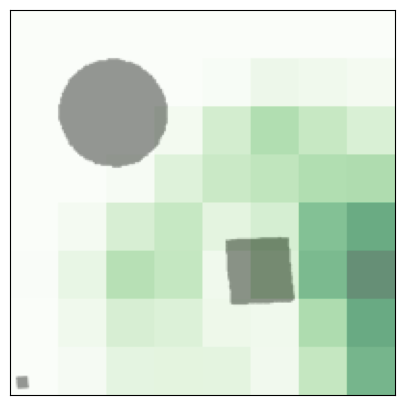

tensor(1, device='cuda:0') square 0.99
{0: {'probability': 1.0, 'label': 'star', 'labelid': 2}, 1: {'probability': 2.4e-08, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


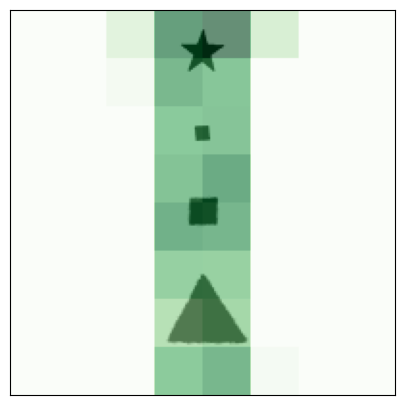

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.990679443, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.009320525, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


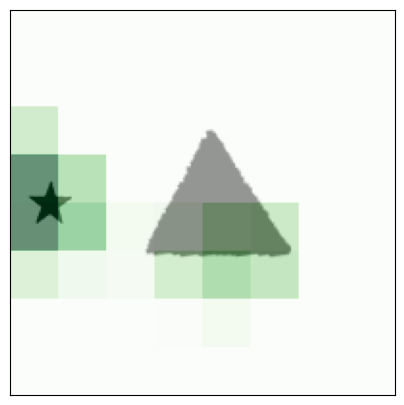

tensor(2, device='cuda:0') star 0.99


In [98]:
XAI_save_path="random_path"
run_experiment_shapes(model_ft, "/content/data/captum-shape-testset/set1/", "Set1 no_pret", XAI_save_path, 0, -1, False, True)
run_experiment_shapes(model_ft, "/content/data/captum-shape-testset/set2/", "Set2 no_pret", XAI_save_path, 0, -1, False, True)